# Importing Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import pandas as pd
import yfinance as yf

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score

# Getting only Close Prices and making a Dataset

In [2]:
folder_path = 'data/new_label_dataset/'

In [3]:
start_date = "2017-01-01"
end_date = "2022-12-31"

In [4]:
stock_symbol = 'AUBANK.NS'

In [41]:
# axis_data = yf.download(stock_symbol, start=start_date, end=end_date)

In [42]:
# axis_data.to_csv(f'{folder_path}/{stock_symbol}.csv')

In [43]:
# axis_data.head()

In [44]:
# axis_data['Close'].plot()

In [5]:
aubank_data = pd.read_csv(f'{folder_path}/{stock_symbol}.csv')

In [6]:
aubank_data.shape

(1322, 30)

In [7]:
aubank_data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_9,SMA_21,EMA_9,...,BB_lower,ADX,ADX+DI,ADX-DI,CMF,OBV,CCI,Williams_%R,ATR,Target
0,2017-08-29,265.500000,279.399994,265.500000,272.399994,270.861786,1649802,268.661109,275.953571,269.747170,...,257.109623,46.315878,15.579860,27.511465,0.182936,-7916212.0,-22.486667,-43.905643,11.294367,0.00
1,2017-08-30,275.000000,278.875000,274.225006,275.424988,273.869659,712294,269.036109,275.057142,270.882733,...,258.701281,44.629755,14.862239,26.244265,0.162639,-7203918.0,24.239067,-22.460356,10.919995,0.53
2,2017-08-31,274.899994,278.225006,273.000000,274.725006,273.173615,580208,269.366665,274.077381,271.651188,...,260.456179,43.268357,14.290231,26.136532,0.141817,-7784126.0,30.892280,-16.461228,10.480352,0.50
3,2017-09-01,275.500000,285.000000,273.774994,276.149994,274.590576,1765988,270.174998,273.277380,272.550949,...,262.568087,40.724434,18.056729,23.999530,0.124248,-6018138.0,96.957914,-36.875025,10.537509,0.51
4,2017-09-04,277.875000,282.149994,271.024994,278.500000,276.927307,1182770,271.108331,272.682142,273.740759,...,262.630387,38.798966,16.607432,24.057285,0.144057,-4835368.0,88.353220,-27.083333,10.582363,0.52
5,2017-09-05,280.049988,288.250000,276.575012,286.575012,284.956726,1989224,273.533332,273.030952,276.307610,...,261.445038,36.017884,19.571585,22.056518,0.186246,-2846144.0,177.568397,-6.146744,10.665375,0.57
6,2017-09-06,284.000000,289.000000,281.799988,283.924988,282.321686,1157354,275.899997,273.353571,277.831085,...,260.914892,33.384987,19.092384,20.902004,0.166896,-4003498.0,160.379632,-18.125044,10.403286,0.48
7,2017-09-07,285.625000,288.000000,277.500000,279.350006,277.772491,815452,277.336110,273.527380,278.134870,...,261.370567,31.613485,17.642099,22.425050,0.090621,-4818950.0,117.262176,-34.464264,10.410570,0.47
8,2017-09-08,280.500000,282.750000,275.000000,277.174988,275.609802,831916,278.247220,273.194047,277.942893,...,261.367084,30.339722,16.637531,22.984957,0.036877,-5650866.0,67.870040,-42.232186,10.210966,0.49
9,2017-09-11,279.375000,282.450012,275.500000,279.299988,277.722839,697004,279.013885,273.401188,278.214312,...,261.489833,29.181880,15.770295,21.786860,0.068276,-4953862.0,69.590690,-34.642901,9.967196,0.52


# Working with Spectrograms

In [8]:
sample_data = aubank_data['Close'].values
print(len(sample_data))

1322


In [9]:
reduced_data = sample_data[:30]

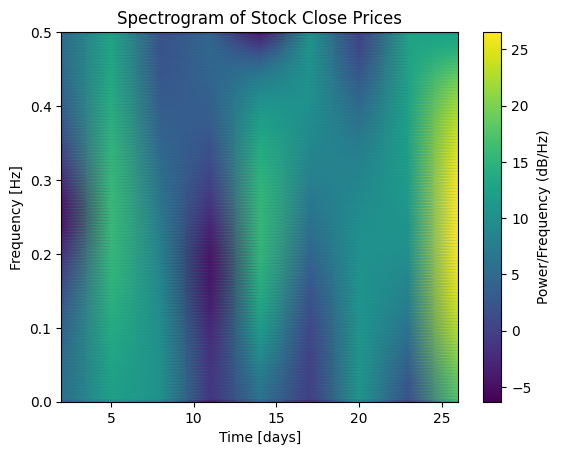

In [10]:
# Compute the spectrogram
frequencies, times, Sxx = spectrogram(reduced_data, fs=1.0, window=('tukey', 0.25), nperseg=4, noverlap=1, nfft=256, detrend='constant', scaling='density', mode='psd')

# Plot the spectrogram
plt.pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [days]')
plt.title('Spectrogram of Stock Close Prices')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.show()

In [11]:
print(type(Sxx))
print(Sxx.shape)
print(type(frequencies))
print(frequencies.shape)
print(type(times))
print(times.shape)

<class 'numpy.ndarray'>
(129, 9)
<class 'numpy.ndarray'>
(129,)
<class 'numpy.ndarray'>
(9,)


In [12]:
print(times)

[ 2.  5.  8. 11. 14. 17. 20. 23. 26.]


In [13]:
print(frequencies)

[0.         0.00390625 0.0078125  0.01171875 0.015625   0.01953125
 0.0234375  0.02734375 0.03125    0.03515625 0.0390625  0.04296875
 0.046875   0.05078125 0.0546875  0.05859375 0.0625     0.06640625
 0.0703125  0.07421875 0.078125   0.08203125 0.0859375  0.08984375
 0.09375    0.09765625 0.1015625  0.10546875 0.109375   0.11328125
 0.1171875  0.12109375 0.125      0.12890625 0.1328125  0.13671875
 0.140625   0.14453125 0.1484375  0.15234375 0.15625    0.16015625
 0.1640625  0.16796875 0.171875   0.17578125 0.1796875  0.18359375
 0.1875     0.19140625 0.1953125  0.19921875 0.203125   0.20703125
 0.2109375  0.21484375 0.21875    0.22265625 0.2265625  0.23046875
 0.234375   0.23828125 0.2421875  0.24609375 0.25       0.25390625
 0.2578125  0.26171875 0.265625   0.26953125 0.2734375  0.27734375
 0.28125    0.28515625 0.2890625  0.29296875 0.296875   0.30078125
 0.3046875  0.30859375 0.3125     0.31640625 0.3203125  0.32421875
 0.328125   0.33203125 0.3359375  0.33984375 0.34375    0.3476

In [15]:
print(Sxx)

[[ 1.72521065  8.79798443  5.30003991 ...  6.16332021  0.79437703
  30.44064774]
 [ 3.44859993 17.60809511 10.59811937 ... 12.32666954  1.59285138
  61.12128959]
 [ 3.44314014 17.64444525 10.59224027 ... 12.32675375  1.6051382
  61.84068262]
 ...
 [ 3.14676874 19.75703206  1.57899603 ...  1.05533514 18.85486304
  20.94680042]
 [ 3.15196048 19.72259266  1.57672309 ...  1.04505647 18.85817778
  20.19042085]
 [ 1.57684624  9.85555172  0.78798283 ...  0.52081426  9.42964101
   9.96904771]]


# Setting up the Prediction Models

In [16]:
def generate_spectrogram(window_data):
    frequencies, times, Sxx = spectrogram(window_data, fs=1.0, window=('tukey', 0.25), nperseg=4, noverlap=1, nfft=256, detrend='constant', scaling='density', mode='psd')
    return frequencies, times, Sxx

In [17]:
aubank_data = pd.read_csv(f'{folder_path}/{stock_symbol}.csv')

1322


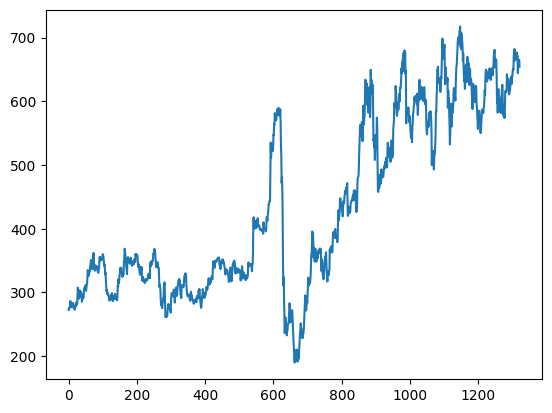

In [18]:
noofdays = 60

close_prices = aubank_data['Close'].values
print(len(close_prices))

# plot the close prices
plt.plot(close_prices)

In [19]:
targets = aubank_data['Target'].values

In [20]:
print(targets)

[0.   0.53 0.5  ... 0.5  0.52 0.43]


In [21]:
# remove the first row of the data
aubank_data = aubank_data.drop(0)
targets = targets[1:]

In [22]:
print(targets)
close_prices = close_prices[1:]

[0.53 0.5  0.51 ... 0.5  0.52 0.43]


In [23]:
X = []
y = []

for i in range(len(close_prices) - noofdays):
    window_data = close_prices[i:i + noofdays]
    spectrogram_data = generate_spectrogram(window_data)
    X.append(spectrogram_data[2])
    y.append(targets[i + noofdays])

In [24]:
print(len(X))
print(len(y))

1261
1261


In [25]:
X = np.array(X)
y = np.array(y)

print(X.shape)
print(y.shape)

(1261, 129, 19)
(1261,)


In [26]:
# split X and y into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train = X[:split_index]
y_train = y[:split_index]

X_test = X[split_index:]
y_test = y[split_index:]

In [27]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1008, 129, 19)
(1008,)
(253, 129, 19)
(253,)


# Preprocess Function

In [28]:
def preprocess_data(X_train, X_test, num_channels=3):
    X_train = torch.tensor(X_train, dtype=torch.float32).reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
    X_test = torch.tensor(X_test, dtype=torch.float32).reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

    X_train = X_train.repeat(1, num_channels, 1, 1)
    X_test = X_test.repeat(1, num_channels, 1, 1)
    
    return X_train, X_test

# AlexNet

In [55]:
def doAlexnet(X_train, y_train, X_test, y_test):

    X_train, X_test = preprocess_data(X_train, X_test)

    y_train = torch.tensor(y_train, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)
        
    X_train = F.interpolate(X_train, size=(224, 224), mode='bilinear', align_corners=False)
    X_test = F.interpolate(X_test, size=(224, 224), mode='bilinear', align_corners=False)

    # size of x_Train is 1008, 3, 224, 224
    # size of y_train is 1008
    # size of x_test is 252, 3, 224, 224
    # size of y_test is 252

    # Load pretrained AlexNet and modify it for regression
    model = models.alexnet(pretrained=True)
    
    # Modify the classifier to have a single output neuron for regression
    model.classifier[6] = nn.Sequential(
        nn.Linear(in_features=4096, out_features=1),  # 1 output neuron for regression
        # nn.Sigmoid()  # Removed Sigmoid to allow more flexibility in output range
    )
    
    # Use Mean Absolute Error Loss (MAE)
    criterion = nn.L1Loss()  # L1Loss for MAE
    
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    num_epochs = 10
    batch_size = 32

    X_train, X_test = X_train.to(device), X_test.to(device)
    y_train, y_test = y_train.to(device), y_test.to(device)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model.train()  

    for epoch in range(num_epochs):
        running_loss = 0.0
        total_train_outputs = []
        total_mae_loss = 0.0  # Initialize total MAE loss for the epoch

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  
            outputs = model(inputs).squeeze()  # Squeeze to remove extra dimensions

            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            # Calculate MAE for this batch
            mae = torch.mean(torch.abs(outputs - labels)).item()  # Calculate MAE for the current batch
            total_mae_loss += mae * len(labels)  # Sum the MAE over all samples in this batch

            # print(loss.item())
            # print(len(inputs))
            # print(len(labels))
            # print(len(outputs))
            # print(len(total_train_outputs))

            # Collect outputs for inspection
            total_train_outputs.extend(outputs.cpu().detach().numpy())

        # Calculate average MAE loss for the epoch
        average_mae_loss = total_mae_loss / len(train_loader.dataset)  # Divide by total number of training samples
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train MAE Loss: {average_mae_loss:.4f}')  # Print average MAE loss
        print(f'Training Outputs: {[round(output, 2) for output in total_train_outputs[:10]]}')  # Print first 10 predicted values
        print(f'Training Labels: {[round(label.item(), 2) for label in y_train[:10]]}')  # Print first 10 true values

    outputs_test = []
    model.eval() 
    with torch.no_grad():
        total_loss = 0.0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Round the output to 2 decimal places and append to the list
            outputs_test.extend([round(float(output), 2) for output in outputs.cpu()])

        # Print MAE loss on the test set
        print(f'Test MAE Loss: {total_loss / len(test_loader.dataset):.4f}')  # Calculate average MAE on the test set
        print(f'Test Outputs: {outputs_test[:10]}')  # Print first 10 predicted test values
        print(f'Test Labels: {[round(label.item(), 2) for label in y_test[:10]]}')  # Print first 10 true test values

    return y_test, outputs_test

In [56]:
y_test, outputs_test = doAlexnet(X_train, y_train, X_test, y_test)

Epoch [1/10], Train MAE Loss: 12.4814
Training Outputs: [-6.46, -14.62, -15.01, -3.38, -17.61, -14.79, -6.65, -17.75, -9.95, -10.5]
Training Labels: [0.49, 0.52, 0.55, 0.54, 0.54, 0.52, 0.46, 0.49, 0.46, 0.52]
Epoch [2/10], Train MAE Loss: 0.1650
Training Outputs: [0.57, 0.59, 0.54, 0.58, 0.63, 0.59, 0.56, 0.56, 0.6, 0.62]
Training Labels: [0.49, 0.52, 0.55, 0.54, 0.54, 0.52, 0.46, 0.49, 0.46, 0.52]
Epoch [3/10], Train MAE Loss: 0.0599
Training Outputs: [0.45, 0.43, 0.45, 0.44, 0.41, 0.42, 0.44, 0.45, 0.44, 0.44]
Training Labels: [0.49, 0.52, 0.55, 0.54, 0.54, 0.52, 0.46, 0.49, 0.46, 0.52]
Epoch [4/10], Train MAE Loss: 0.0571
Training Outputs: [0.51, 0.53, 0.53, 0.53, 0.53, 0.51, 0.52, 0.51, 0.53, 0.51]
Training Labels: [0.49, 0.52, 0.55, 0.54, 0.54, 0.52, 0.46, 0.49, 0.46, 0.52]
Epoch [5/10], Train MAE Loss: 0.0569
Training Outputs: [0.51, 0.52, 0.49, 0.46, 0.52, 0.48, 0.5, 0.48, 0.46, 0.47]
Training Labels: [0.49, 0.52, 0.55, 0.54, 0.54, 0.52, 0.46, 0.49, 0.46, 0.52]
Epoch [6/10], Tr

# ResNet

In [75]:
def doresNet(X_train, y_train, X_test, y_test):

    X_train, X_test = preprocess_data(X_train, X_test)

    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    X_train = F.interpolate(X_train, size=(224, 224), mode='bilinear', align_corners=False)
    X_test = F.interpolate(X_test, size=(224, 224), mode='bilinear', align_corners=False)

    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 2) 

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    num_epochs = 10
    batch_size = 32

    X_train, X_test = X_train.to(device), X_test.to(device)
    y_train, y_test = y_train.to(device), y_test.to(device)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  
            outputs = model(inputs) 

            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step() 

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')


    model.eval() 
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        print(f'Test Accuracy: {test_accuracy:.2f}%')


# DenseNet

In [78]:
def doDenseNet(X_train, y_train, X_test, y_test):
    
    X_train, X_test = preprocess_data(X_train, X_test)

    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    X_train = F.interpolate(X_train, size=(224, 224), mode='bilinear', align_corners=False)
    X_test = F.interpolate(X_test, size=(224, 224), mode='bilinear', align_corners=False)

    model = models.densenet121(pretrained=True)
    model.classifier = nn.Linear(model.classifier.in_features, 2)  

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    num_epochs = 10
    batch_size = 32

    X_train, X_test = X_train.to(device), X_test.to(device)
    y_train, y_test = y_train.to(device), y_test.to(device)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  
            outputs = model(inputs) 

            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step() 

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')


    model.eval() 
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        print(f'Test Accuracy: {test_accuracy:.2f}%')


# EfficientNet

In [82]:
def doEfficientNet(X_train, y_train, X_test, y_test):
    
    X_train, X_test = preprocess_data(X_train, X_test)

    y_train = torch.tensor(y_train, dtype=torch.long)
    y_test = torch.tensor(y_test, dtype=torch.long)

    X_train = F.interpolate(X_train, size=(224, 224), mode='bilinear', align_corners=False)
    X_test = F.interpolate(X_test, size=(224, 224), mode='bilinear', align_corners=False)

    model = models.efficientnet_b0(pretrained=True)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 2)  

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    num_epochs = 10
    batch_size = 32

    X_train, X_test = X_train.to(device), X_test.to(device)
    y_train, y_test = y_train.to(device), y_test.to(device)

    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model.train()  
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  
            outputs = model(inputs) 

            loss = criterion(outputs, labels)  
            loss.backward()
            optimizer.step() 

            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')


    model.eval() 
    with torch.no_grad():
        correct = 0
        total = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = 100 * correct / total
        print(f'Test Accuracy: {test_accuracy:.2f}%')

# Testing out Performances

In [74]:
doAlexnet(X_train, y_train, X_test, y_test)

c:\Users\Pdogg Windows10\Desktop\Semester 7\Natural Language Processing\Project\nlp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 646.0083, Training Accuracy: 54.25%
Epoch [2/10], Loss: 17.3811, Training Accuracy: 47.68%
Epoch [3/10], Loss: 17.5825, Training Accuracy: 48.32%
Epoch [4/10], Loss: 17.5598, Training Accuracy: 48.45%
Epoch [5/10], Loss: 17.3889, Training Accuracy: 50.77%
Epoch [6/10], Loss: 17.3170, Training Accuracy: 49.48%
Epoch [7/10], Loss: 17.4064, Training Accuracy: 48.45%
Epoch [8/10], Loss: 17.3287, Training Accuracy: 51.29%
Epoch [9/10], Loss: 17.3329, Training Accuracy: 48.07%
Epoch [10/10], Loss: 17.5446, Training Accuracy: 52.84%
Test Accuracy: 54.12%


In [77]:
doresNet(X_train, y_train, X_test, y_test)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Pdogg Windows10/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100.0%


Epoch [1/10], Loss: 18.0213, Training Accuracy: 49.10%
Epoch [2/10], Loss: 17.6782, Training Accuracy: 47.29%
Epoch [3/10], Loss: 17.4809, Training Accuracy: 51.68%
Epoch [4/10], Loss: 17.5110, Training Accuracy: 50.64%
Epoch [5/10], Loss: 17.6908, Training Accuracy: 50.39%
Epoch [6/10], Loss: 18.4702, Training Accuracy: 49.87%
Epoch [7/10], Loss: 17.5896, Training Accuracy: 51.93%
Epoch [8/10], Loss: 17.6114, Training Accuracy: 49.61%
Epoch [9/10], Loss: 17.8168, Training Accuracy: 50.39%
Epoch [10/10], Loss: 17.2569, Training Accuracy: 51.16%
Test Accuracy: 54.12%


In [80]:
doDenseNet(X_train, y_train, X_test, y_test)

c:\Users\Pdogg Windows10\Desktop\Semester 7\Natural Language Processing\Project\nlp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pdogg Windows10\Desktop\Semester 7\Natural Language Processing\Project\nlp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to C:\Users\Pdogg Windows10/.cache\torch\hub\checkpoints\densenet121-a639ec97.pth
100.0%


Epoch [1/10], Loss: 18.2298, Training Accuracy: 50.13%
Epoch [2/10], Loss: 17.4991, Training Accuracy: 49.10%
Epoch [3/10], Loss: 17.8994, Training Accuracy: 49.10%
Epoch [4/10], Loss: 17.6370, Training Accuracy: 50.39%
Epoch [5/10], Loss: 18.5653, Training Accuracy: 49.36%
Epoch [6/10], Loss: 17.8271, Training Accuracy: 47.04%
Epoch [7/10], Loss: 17.6489, Training Accuracy: 50.64%
Epoch [8/10], Loss: 18.3603, Training Accuracy: 51.68%
Epoch [9/10], Loss: 17.5201, Training Accuracy: 50.90%
Epoch [10/10], Loss: 17.3769, Training Accuracy: 51.42%
Test Accuracy: 45.88%


In [83]:
doEfficientNet(X_train, y_train, X_test, y_test)

c:\Users\Pdogg Windows10\Desktop\Semester 7\Natural Language Processing\Project\nlp\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pdogg Windows10\Desktop\Semester 7\Natural Language Processing\Project\nlp\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/10], Loss: 18.2757, Training Accuracy: 47.94%
Epoch [2/10], Loss: 17.7647, Training Accuracy: 50.13%
Epoch [3/10], Loss: 17.6910, Training Accuracy: 50.52%
Epoch [4/10], Loss: 17.4698, Training Accuracy: 51.29%
Epoch [5/10], Loss: 17.6021, Training Accuracy: 50.77%
Epoch [6/10], Loss: 17.4567, Training Accuracy: 48.58%
Epoch [7/10], Loss: 17.5328, Training Accuracy: 48.84%
Epoch [8/10], Loss: 17.5780, Training Accuracy: 51.16%
Epoch [9/10], Loss: 17.4795, Training Accuracy: 49.61%
Epoch [10/10], Loss: 17.6611, Training Accuracy: 47.81%
Test Accuracy: 45.88%
